# Testing MPO

In [5]:
%reload_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings('ignore') 

import rdkit
import dgym as dg

# load all data
path = '../../dgym-data'

deck = dg.MoleculeCollection.load(
    f'{path}/DSi-Poised_Library_annotated.sdf',
    reactant_names=['reagsmi1', 'reagsmi2', 'reagsmi3']
)

reactions = dg.ReactionCollection.from_json(
    path = f'{path}/All_Rxns_rxn_library_sorted.json',
    smarts_col = 'reaction_string',
    classes_col = 'functional_groups'
)

building_blocks = dg.datasets.disk_loader(f'{path}/Enamine_Building_Blocks_Stock_262336cmpd_20230630.sdf')
fingerprints = dg.datasets.fingerprints(f'{path}/Enamine_Building_Blocks_Stock_262336cmpd_20230630_atoms.fpb')

import torch
import pyarrow.parquet as pq
table = pq.read_table('../../dgym-data/sizes.parquet')[0]
sizes = torch.tensor(table.to_numpy())

Make oracles.

In [6]:
import os

dockstring_dir = f'{path}/dockstring_targets/'
files = os.listdir(dockstring_dir)
configs = sorted([f for f in files if 'conf' in f])
targets = sorted([f for f in files if 'target' in f])

idx = 0
with open(dockstring_dir + configs[idx], 'r') as f:
    config_ = f.readlines()
    config_ = [c.replace('\n', '') for c in config_]
    config_ = [c.split(' = ') for c in config_ if c]
    config_ = {c[0]: float(c[1]) for c in config_}

target = targets[idx]
name = target.split('_')[0]

config_.update({
    'size_x': 22.5,
    'size_y': 22.5,
    'size_z': 22.5,
})

from dgym.envs.oracle import DockingOracle, CatBoostOracle, RDKitOracle, NoisyOracle
from dgym.envs.utility import ClassicUtilityFunction

config = {
    'search_mode': 'detailed',
    'scoring': 'vina',
    'seed': 5,
    **config_
}

docking_oracle = DockingOracle(
    f'{name} affinity',
    receptor_path=f'{path}/dockstring_targets/{name}_target.pdbqt',
    config=config
)
log_P_oracle = RDKitOracle('MolLogP')
log_S_oracle = CatBoostOracle(
    'Log S', path='../../dgym-data/models/aqsolcb.model')

# create evaluators
docking_utility_function = ClassicUtilityFunction(
    docking_oracle,
    ideal=(9.5, 13),
    acceptable=(9, 13)
)

log_P_utility_function = ClassicUtilityFunction(
    log_P_oracle,
    ideal=(0.5, 1.85),
    acceptable=(-0.5, 3.5)
)

log_S_utility_function = ClassicUtilityFunction(
    log_S_oracle,
    ideal=(-1, 1),
    acceptable=(-4, 1)
)

assays = [
    docking_oracle,
    log_P_oracle,
    log_S_oracle
]

utility_functions = [
    docking_utility_function,
    log_P_utility_function,
    log_S_utility_function
]

Instantiate designer.

In [7]:
from dgym.envs.designer import Designer, Generator

designer = Designer(
    Generator(building_blocks, fingerprints, sizes),
    reactions,
    cache = True
)

Pick 5 random starting hits.

In [112]:
# select first molecule
import random
def select_molecule(deck):
    initial_index = random.randint(0, len(deck) - 1)
    initial_molecule = deck[initial_index]
    if len(initial_molecule.reactants) == 2 \
        and designer.match_reactions(initial_molecule):
        return initial_molecule
    else:
        return select_molecule(deck)

initial_molecules = [select_molecule(deck) for _ in range(5)]
initial_library = dg.MoleculeCollection(initial_molecules)
initial_library.update_annotations()
library = initial_library

Prepare MPO ranking function.

In [113]:
import numpy as np
from pymoo.util.nds.non_dominated_sorting import NonDominatedSorting

def rank_molecules(utility):
    
    costs = -utility

    # Multi-dimensional non-dominated fusion sort
    costs = np.nan_to_num(costs, 1e2)
    nds, nds_ranks = NonDominatedSorting().do(
        costs, return_rank=True, only_non_dominated_front=False)
    penalty_sums = np.sum(costs, axis=1)
    fused_ranks = np.lexsort([penalty_sums, nds_ranks])
    
    return fused_ranks.tolist()

In [114]:
from dgym.envs.utility import MultipleUtilityFunction

multiple_utility_function = MultipleUtilityFunction(
    utility_functions, weights=[0.6, 0.2, 0.2]
)

Multi-step selection.

In [ ]:
import numpy as np
from tqdm.notebook import tqdm

for molecule in library:
    molecule.update_annotations(
        {'timestep': 0, **{a.name: a(molecule) for a in assays}})

utility = multiple_utility_function.score(library)
composite_utility = multiple_utility_function(initial_library)
best = np.argsort(np.negative(composite_utility)).tolist()

print(utility[best])
print(best)

temperature = 1.0
for step in tqdm(range(1, 15)):
    
    if step % 15 == 0:
        temperature -= 0.2
    
    analogs = []
    for b in best:
        if step % 5 == 2:
            analogs += designer.design(
                library[b], 8, strategy='grow')
        else:
            analogs += designer.design(
                library[b], 8, strategy='replace', temperature=temperature)
    
    # Get utility
    library += analogs
    composite_utility = multiple_utility_function(library)
    best = np.argsort(np.negative(composite_utility))[:5].tolist()

    for analog in analogs:
        analog.update_annotations(
            {'timestep': step, **{a.name: a(analog) for a in assays}})

    utility = multiple_utility_function.score(library)
    print(step, np.round(utility[best], 3))
    print(step, best)

# Visualizing results

(3.0, 9.521564615087023)

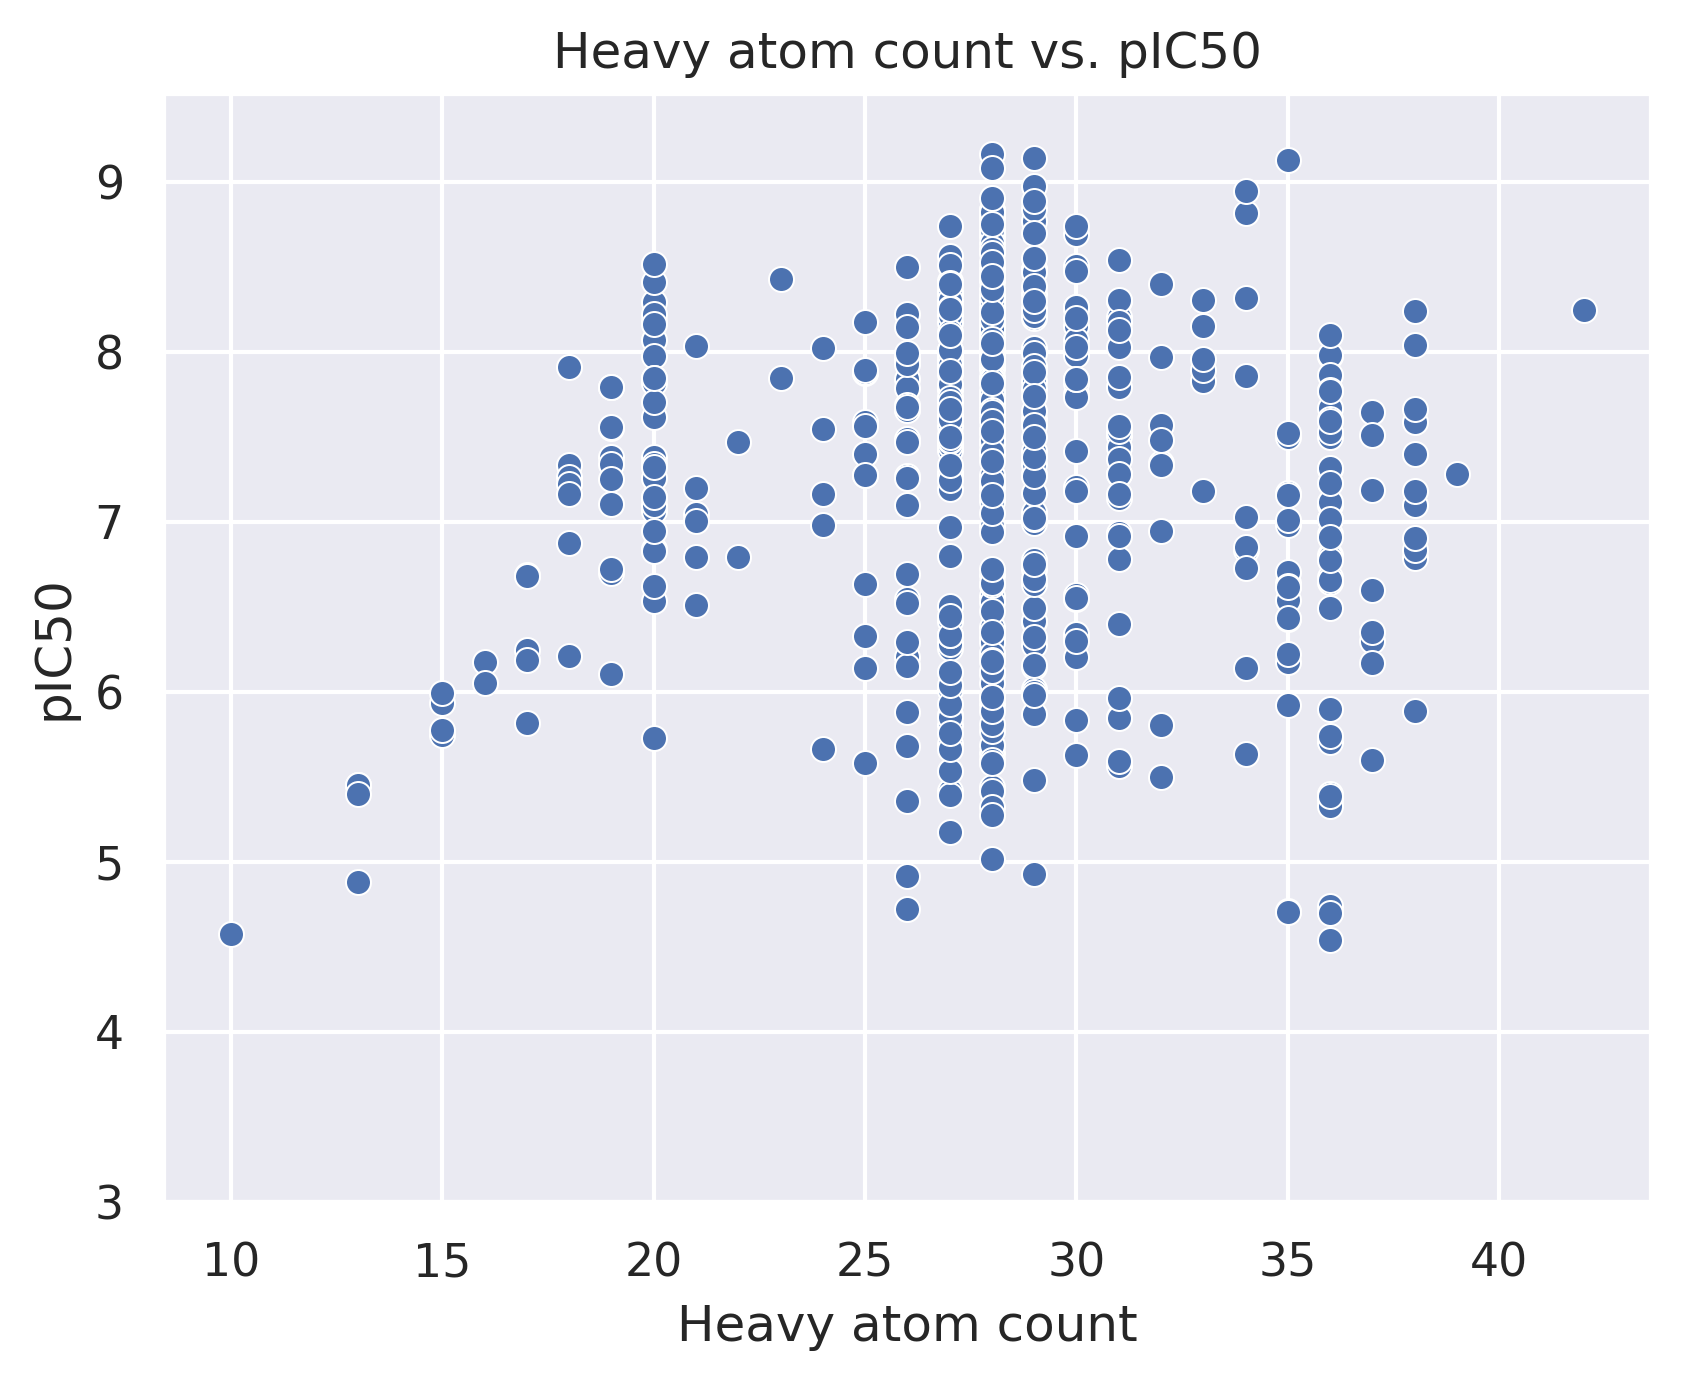

In [85]:
import seaborn as sns
import matplotlib.pyplot as plt
from rdkit.Chem.Descriptors import HeavyAtomCount

plt.figure(dpi=300)
sns.set()
sns.scatterplot(
    x=[HeavyAtomCount(m.mol) for m in library],
    y=docking_oracle(library),
)

plt.xlabel('Heavy atom count')
plt.ylabel('pIC50')
plt.title('Heavy atom count vs. pIC50')
plt.ylim(3)

<Figure size 1920x1440 with 0 Axes>

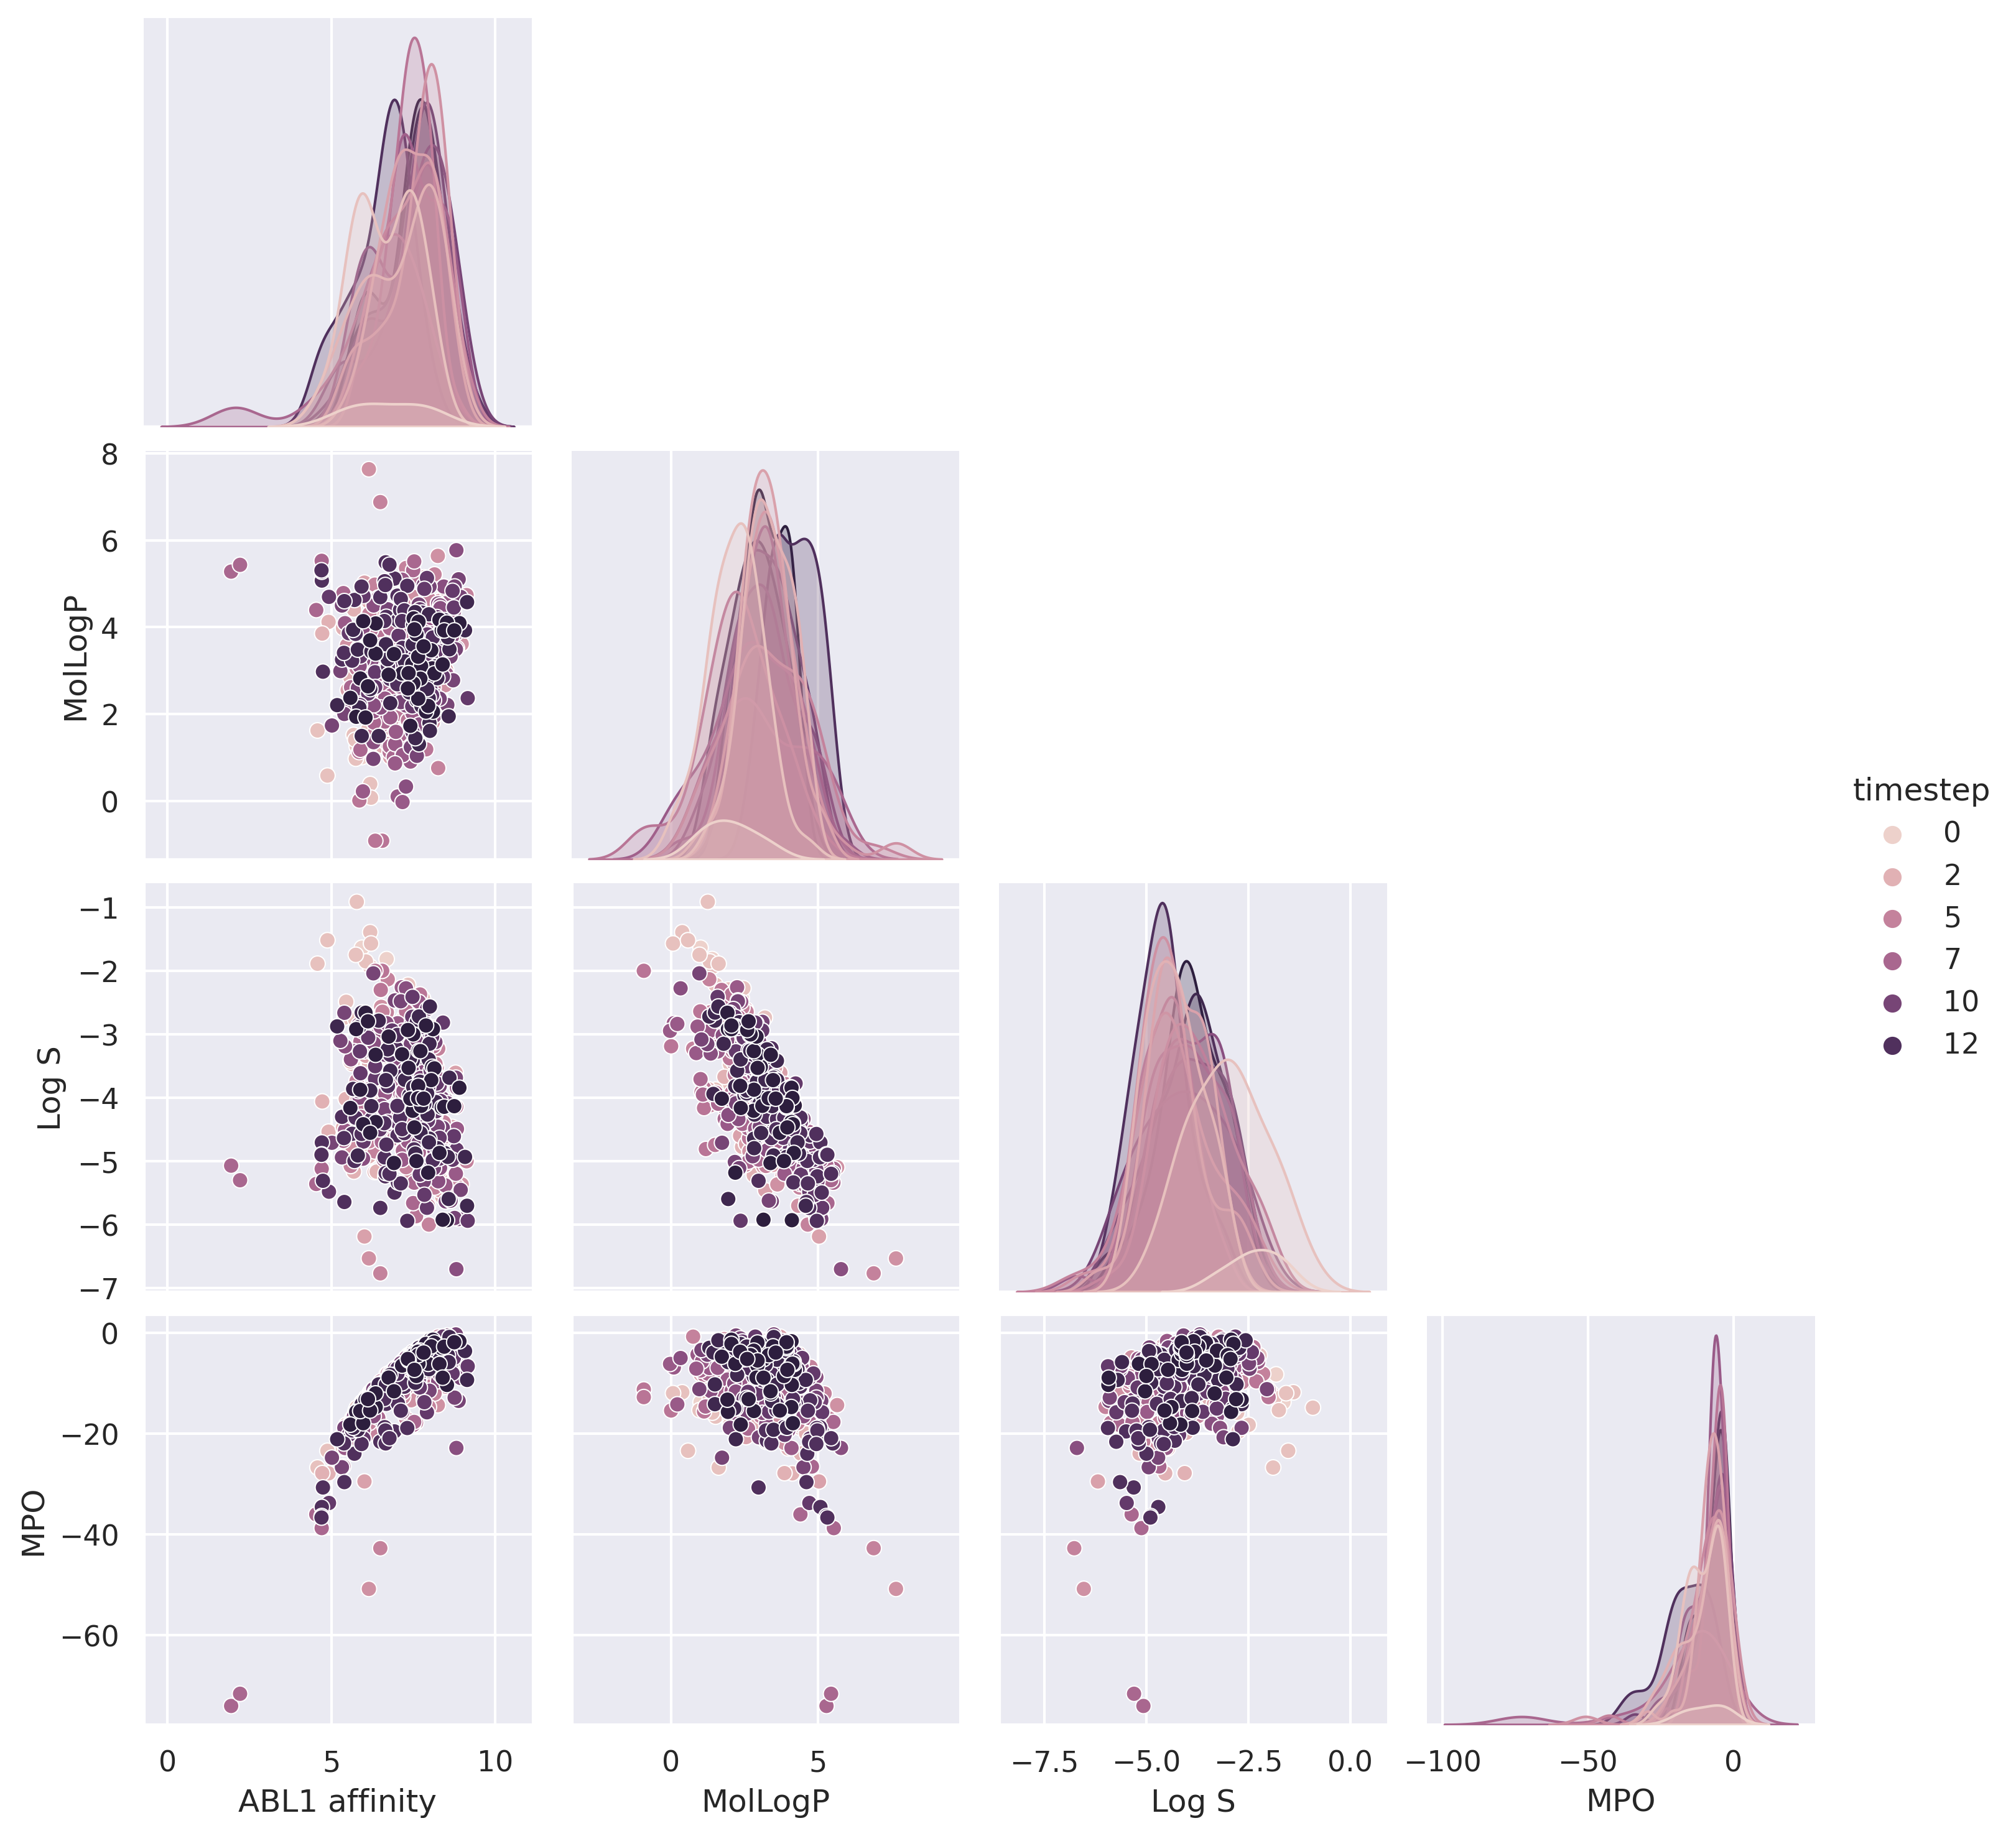

In [86]:
import pandas as pd

plt.figure(dpi=300)

pairplot_df = (
    library.annotations[
        ['ABL1 affinity', 'MolLogP', 'Log S', 'timestep']
    ].map(
        lambda x: x[0] if isinstance(x, list) else x
    ).dropna()
)

pairplot_df['MPO'] = np.zeros(len(pairplot_df))
for i, utility_function in enumerate(utility_functions):
    pairplot_df['MPO'] += pairplot_df.iloc[:,i].apply(utility_function)

sns.set_theme()
g = sns.pairplot(
    pairplot_df,
    corner=True,
    hue='timestep'
)
g.fig.set_dpi(300)

## Visualizing the best across rounds

A trajectory of the best molecule each round.

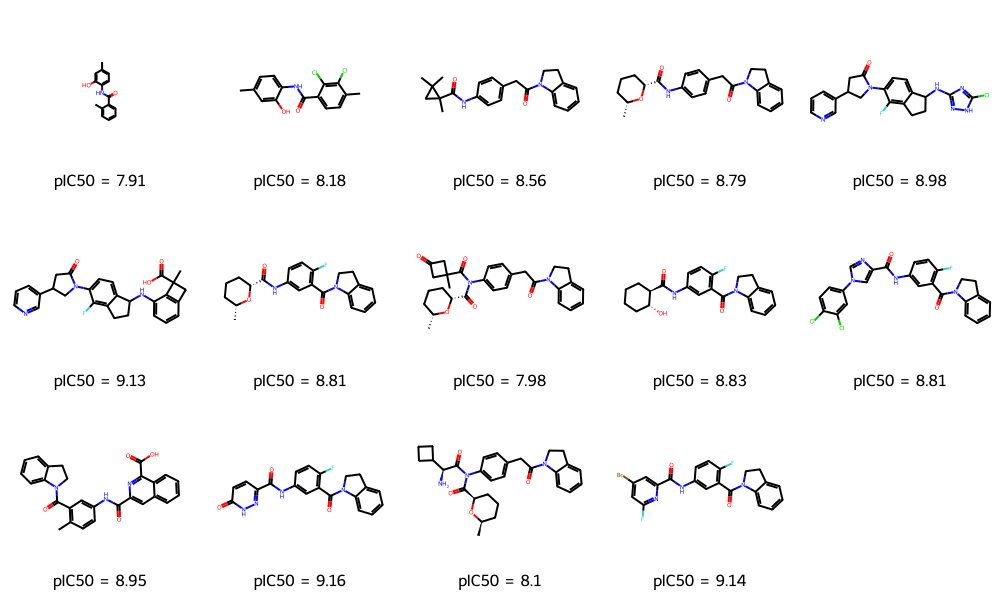

In [87]:
best_across_round = [
    library.annotations.query(f'timestep == {i}')[f'{name} affinity']
    .sort_values(na_position='first')
    .index[-1].item()
    for i in range(int(library.annotations.timestep.max()))
    if library.annotations.query(f'timestep == {i}')[f'{name} affinity'].any()
]

from rdkit.Chem.Draw import MolsToGridImage

get_affinity = lambda idx: library[idx][f'{name} affinity'][0]
MolsToGridImage(
    [m.mol for m in library[best_across_round]],
    molsPerRow=5,
    legends=[f'pIC50 = {round(get_affinity(b), 2)}' for b in best_across_round]
)

A trajectory of the best molecule.

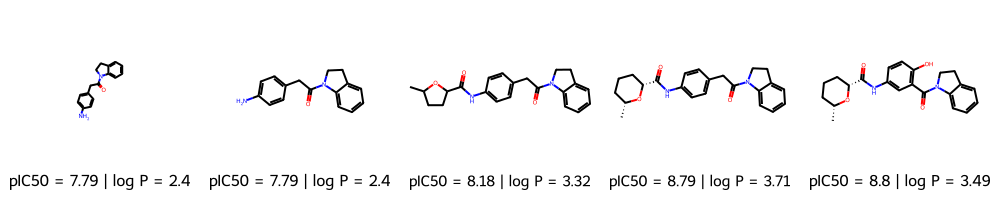

In [88]:
# mol = library[np.nanargmax(docking_oracle(library)).item()]
mol = library[best[0]]
milestones = [mol]
while mol.inspiration:
    milestones.append(mol.inspiration)
    mol = mol.inspiration
    
milestones = list(reversed(milestones))
MolsToGridImage(
    [m.mol for m in milestones],
    molsPerRow=5,
    legends=[f'pIC50 = {round(docking_oracle(m)[0], 2)} | log P = {round(log_P_oracle(m)[0], 2)}' for m in milestones]
)

Text(0.5, 1.0, 'New compounds synthesized each round')

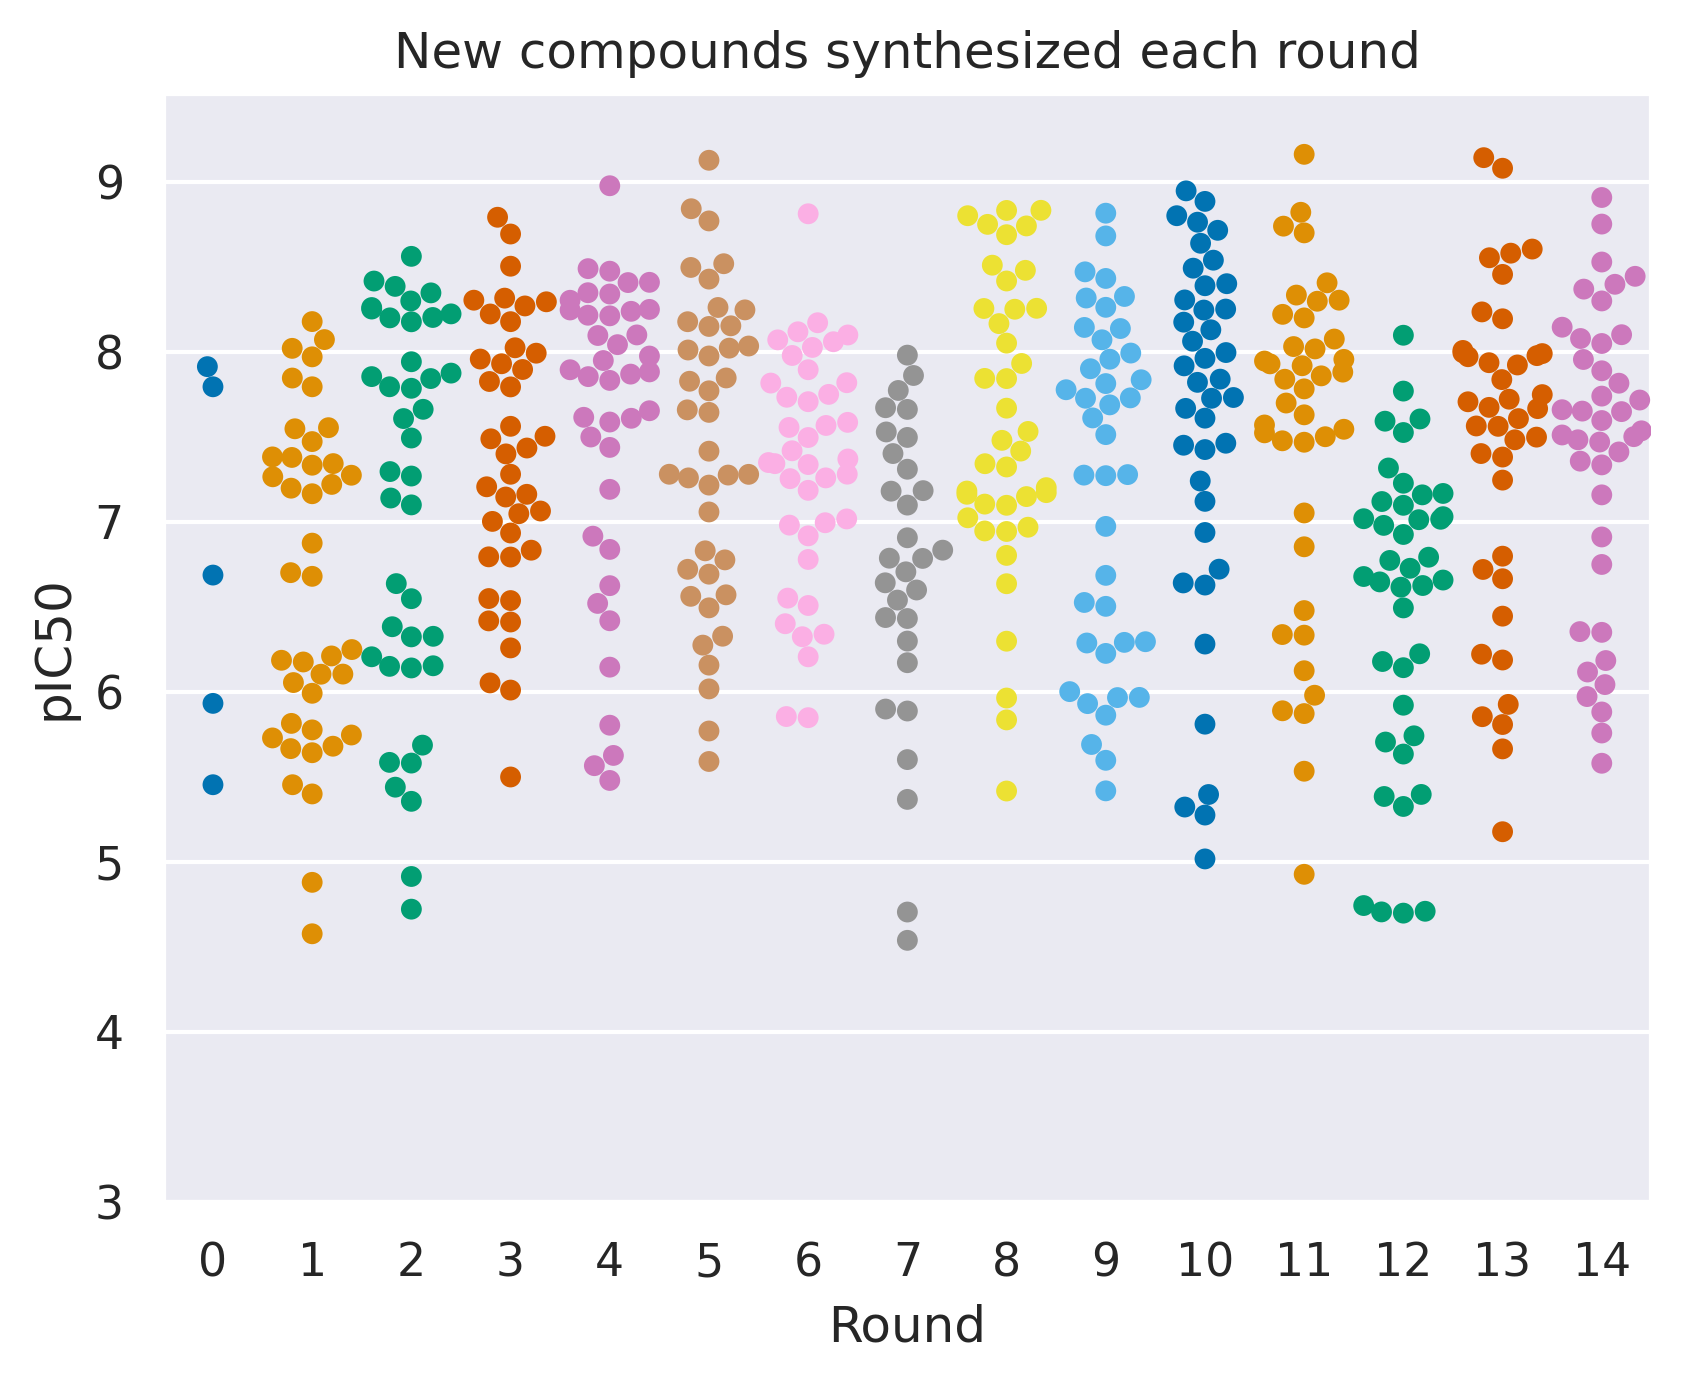

In [89]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(dpi=300)
sns.set()

objective = f'{name} affinity'

sns.swarmplot(
    pairplot_df,
    x='timestep',
    y=objective,
    hue='timestep',
    palette='colorblind',
    # complementary=True,
    legend=False
)

plt.ylim(3)
plt.ylabel('pIC50')
plt.xlabel('Round')
plt.title('New compounds synthesized each round')

In [90]:
max_timestep = int(library.annotations.timestep.max())

records = []
for timestep, group in pairplot_df.groupby('timestep'):
    for _, mol in group.iterrows():
        record = {
            'pIC50': mol[objective], 'timestep': timestep}
        records.append(record)
        
        # Duplicate logic for each possible timestep
        for t in range(1, max_timestep + 1):
            if timestep < t:
                records.append({**record, 'timestep': t})

df = pd.DataFrame(records)

Text(0.5, 1.0, 'Distribution of ligand potencies across rounds')

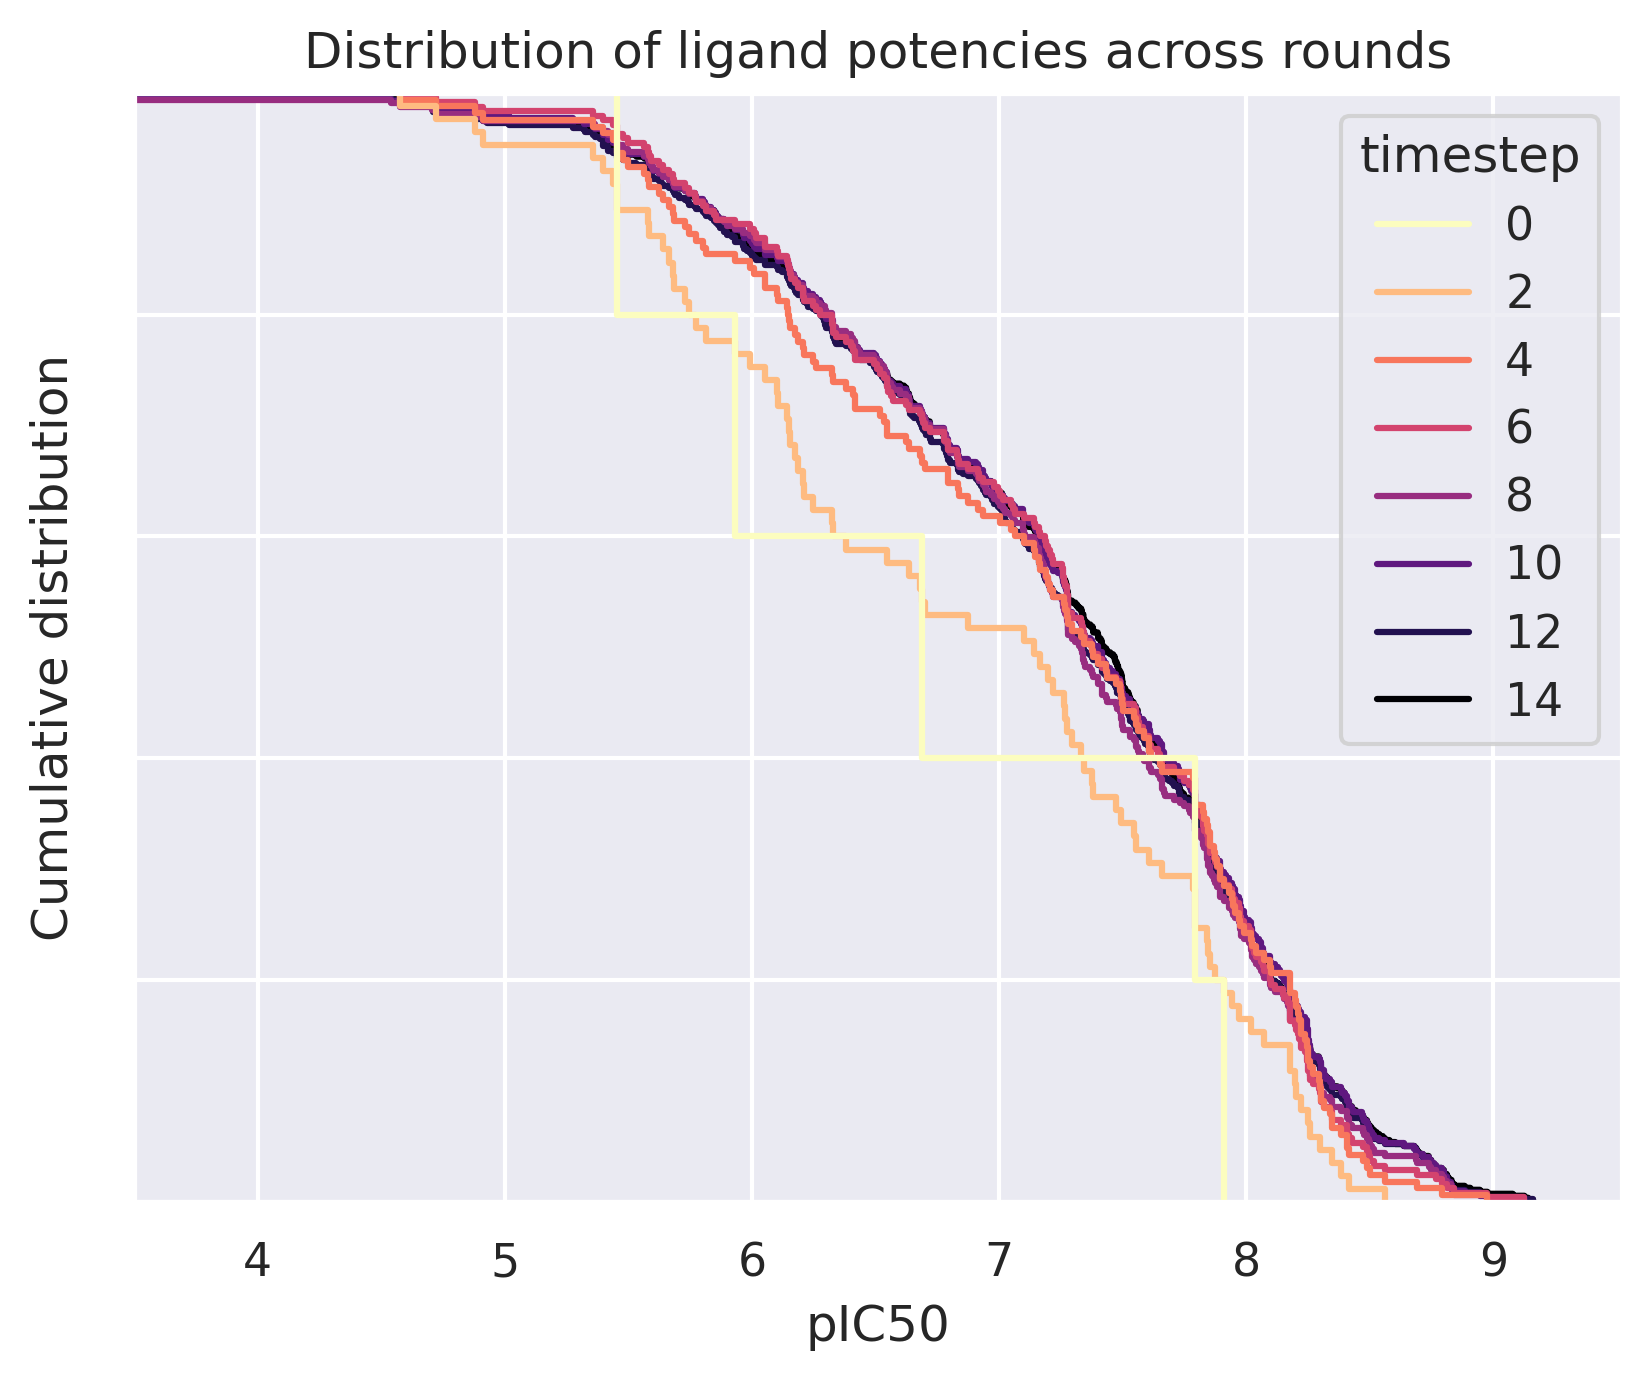

In [91]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()
plt.figure(dpi=300)

g = sns.ecdfplot(
    df.query('timestep % 2 == 0'),
    x='pIC50',
    hue='timestep',
    palette='magma_r',
    complementary=True
)

g.set(yticklabels=[])

plt.xlim(3.5)
plt.xlabel('pIC50')
plt.ylabel('Cumulative distribution')
plt.title('Distribution of ligand potencies across rounds')

Text(0.5, 1.0, 'Assay values across time')

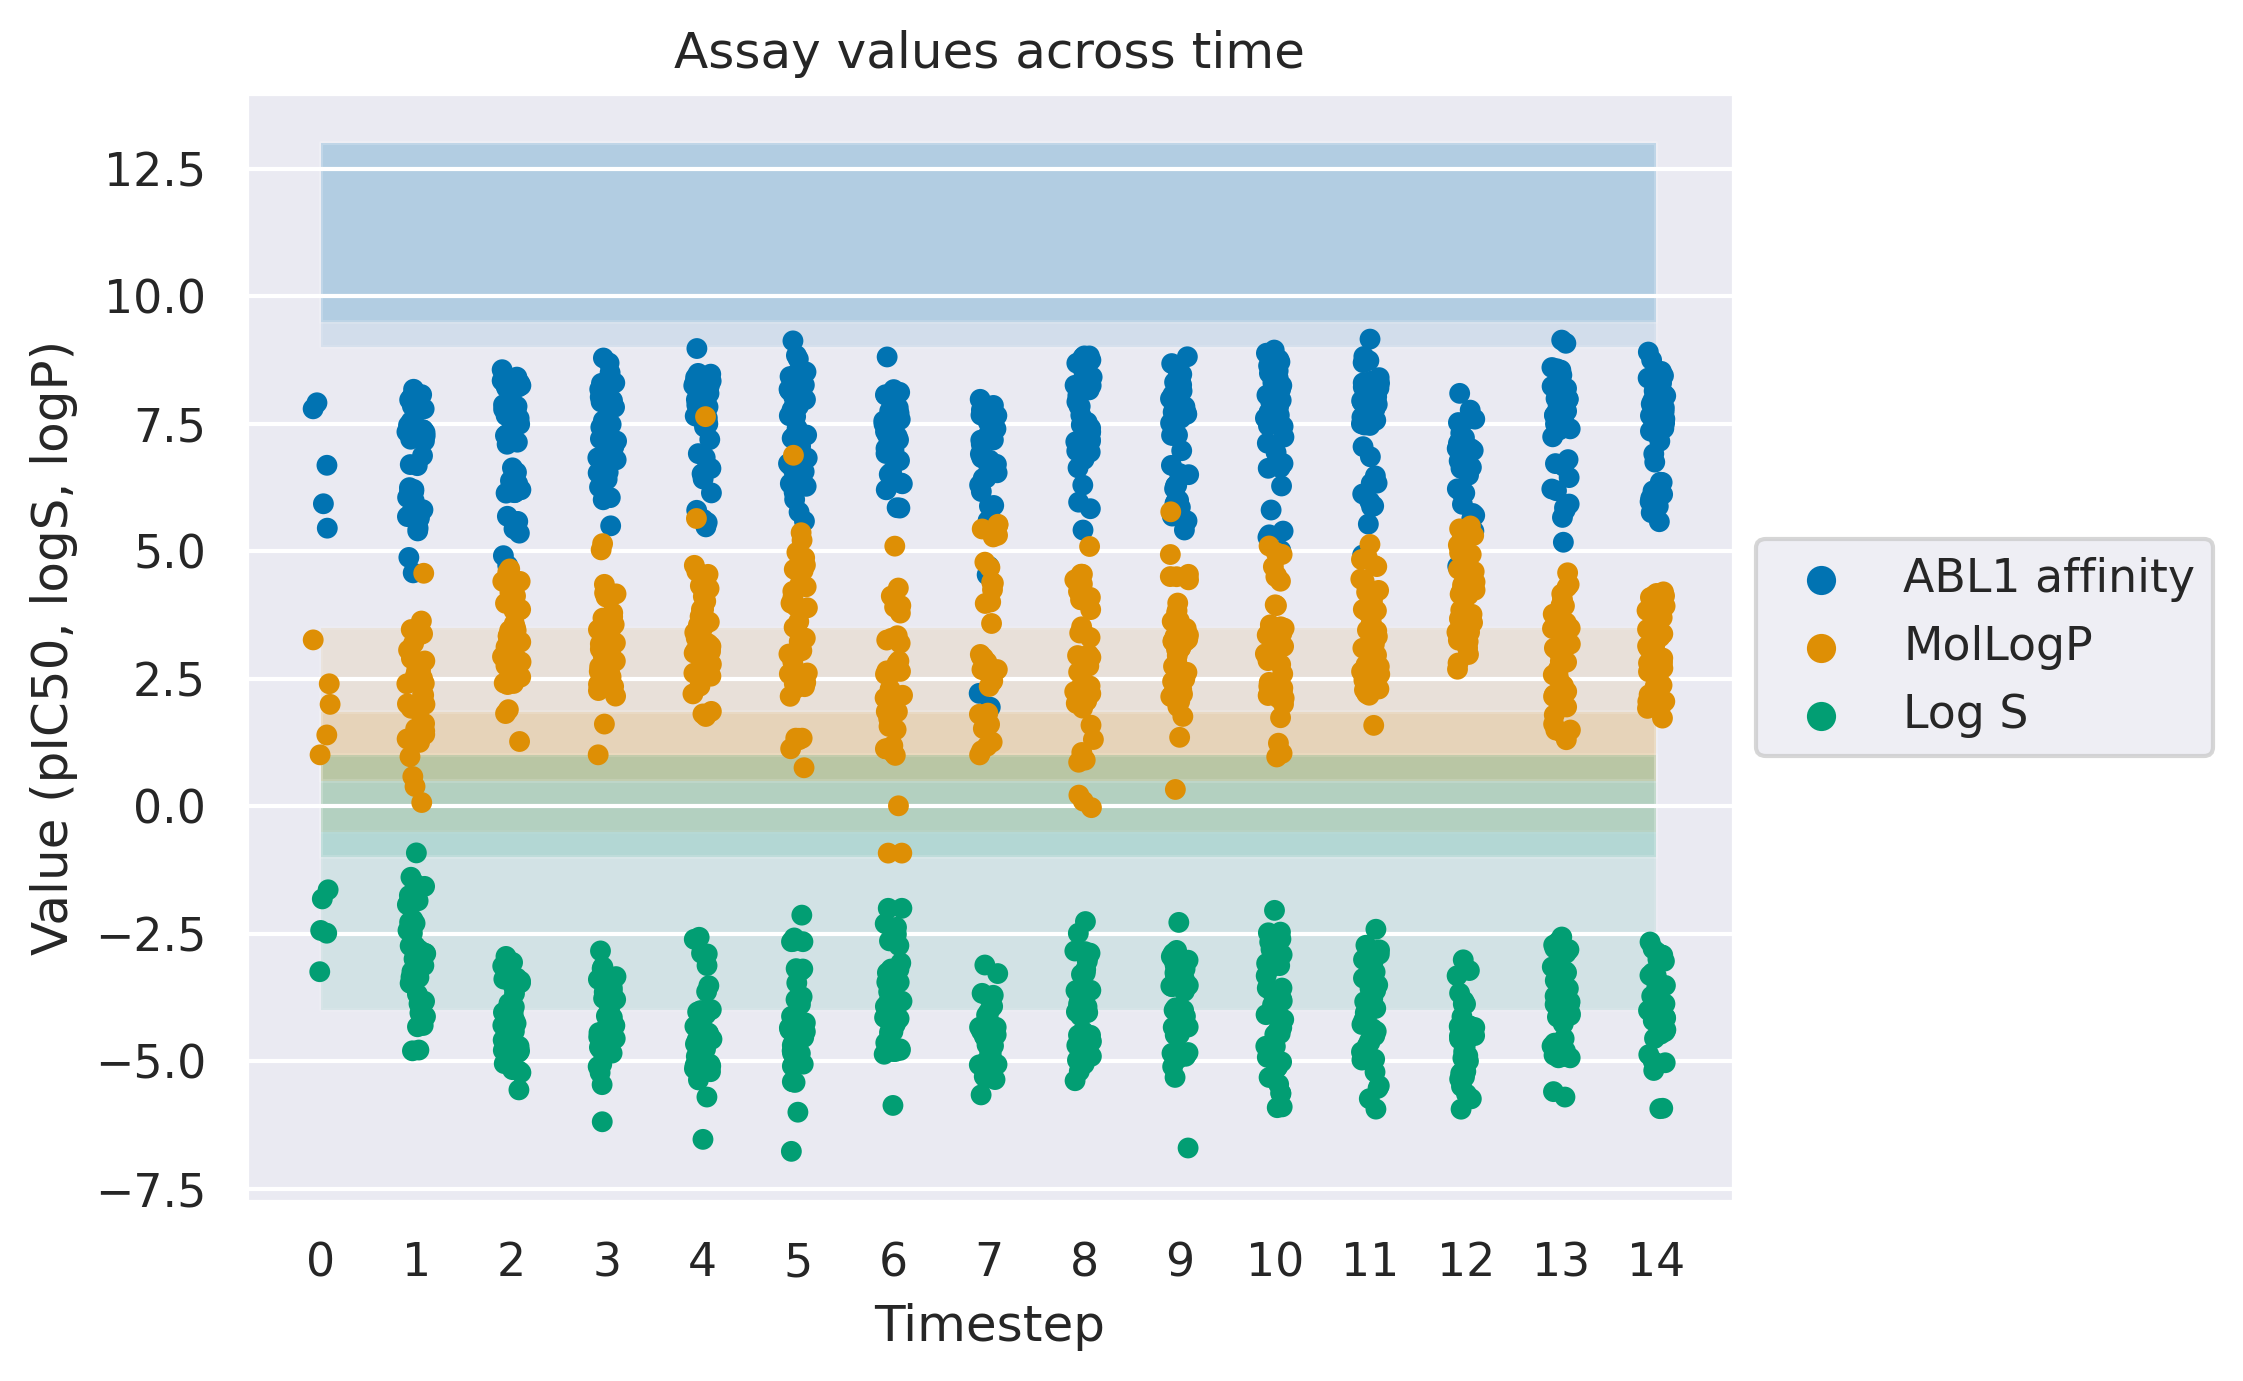

In [92]:
plt.figure(dpi=300)
sns.set_theme()

annotations = (
    library.annotations
    .map(lambda x: x[0] if isinstance(x, list) else x)
    [['timestep', f'{name} affinity', 'MolLogP', 'Log S']]
)

annotations = pd.melt(
    annotations,
    id_vars=['timestep'],
    var_name='assay',
    value_name='value'
)

g = sns.stripplot(
    annotations,
    x='timestep',
    y='value',
    hue='assay',
    palette='colorblind'
)

plt.fill_betweenx(
    log_S_utility_function.acceptable, 0, annotations.timestep.max(), alpha=0.1, zorder=-10,
    facecolor=sns.palettes.color_palette('colorblind')[2]
)
plt.fill_betweenx(
    log_P_utility_function.acceptable, 0, annotations.timestep.max(), alpha=0.1, zorder=-10,
    facecolor=sns.palettes.color_palette('colorblind')[1]
)
plt.fill_betweenx(
    docking_utility_function.acceptable, 0, annotations.timestep.max(), alpha=0.1, zorder=-10,
    facecolor=sns.palettes.color_palette('colorblind')[0]
)

plt.fill_betweenx(
    log_S_utility_function.ideal, 0, annotations.timestep.max(), alpha=0.15, zorder=-10,
    facecolor=sns.palettes.color_palette('colorblind')[2]
)
plt.fill_betweenx(
    log_P_utility_function.ideal, 0, annotations.timestep.max(), alpha=0.15, zorder=-10,
    facecolor=sns.palettes.color_palette('colorblind')[1]
)
plt.fill_betweenx(
    docking_utility_function.ideal, 0, annotations.timestep.max(), alpha=0.15, zorder=-10,
    facecolor=sns.palettes.color_palette('colorblind')[0]
)

g.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel('Timestep')
plt.ylabel('Value (pIC50, logS, logP)')
plt.title('Assay values across time')

In [101]:
results = docking_oracle.predict([library[best[0]]]*10)

In [102]:
results

(['C[C@@H]1CCC[C@H](C(=O)Nc2ccc(O)c(C(=O)N3CCc4ccccc43)c2)O1',
  'C[C@@H]1CCC[C@H](C(=O)Nc2ccc(O)c(C(=O)N3CCc4ccccc43)c2)O1',
  'C[C@@H]1CCC[C@H](C(=O)Nc2ccc(O)c(C(=O)N3CCc4ccccc43)c2)O1',
  'C[C@@H]1CCC[C@H](C(=O)Nc2ccc(O)c(C(=O)N3CCc4ccccc43)c2)O1',
  'C[C@@H]1CCC[C@H](C(=O)Nc2ccc(O)c(C(=O)N3CCc4ccccc43)c2)O1',
  'C[C@@H]1CCC[C@H](C(=O)Nc2ccc(O)c(C(=O)N3CCc4ccccc43)c2)O1',
  'C[C@@H]1CCC[C@H](C(=O)Nc2ccc(O)c(C(=O)N3CCc4ccccc43)c2)O1',
  'C[C@@H]1CCC[C@H](C(=O)Nc2ccc(O)c(C(=O)N3CCc4ccccc43)c2)O1',
  'C[C@@H]1CCC[C@H](C(=O)Nc2ccc(O)c(C(=O)N3CCc4ccccc43)c2)O1',
  'C[C@@H]1CCC[C@H](C(=O)Nc2ccc(O)c(C(=O)N3CCc4ccccc43)c2)O1'],
 [8.178056736926004,
  8.026538040333696,
  8.869694362692304,
  8.224861758258331,
  8.774436510543024,
  7.660241480433546,
  7.887944006153821,
  8.491360283758686,
  8.571775202517287,
  8.397374872275412])

In [107]:
multiple_utility_function(library[best])

[1.0, 0.75, 0.5, 0.25, 0.0]

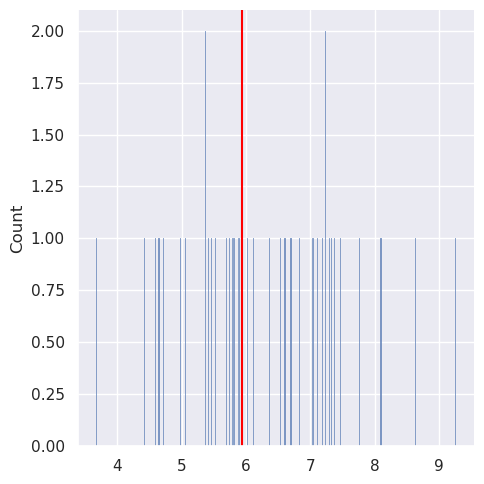

In [283]:
designer.reset()

starting_molecule = initial_library[0] # library[best[0]]
analogs = designer.design(
    starting_molecule, 40, temperature=1.0)
results = docking_oracle(
    analogs, use_cache=False)
sns.displot(results, bins=300)
plt.axvline(
    docking_oracle(starting_molecule), color='red')

Text(0.5, 1.0, 'Great molecules are difficult to improve (top right is best)')

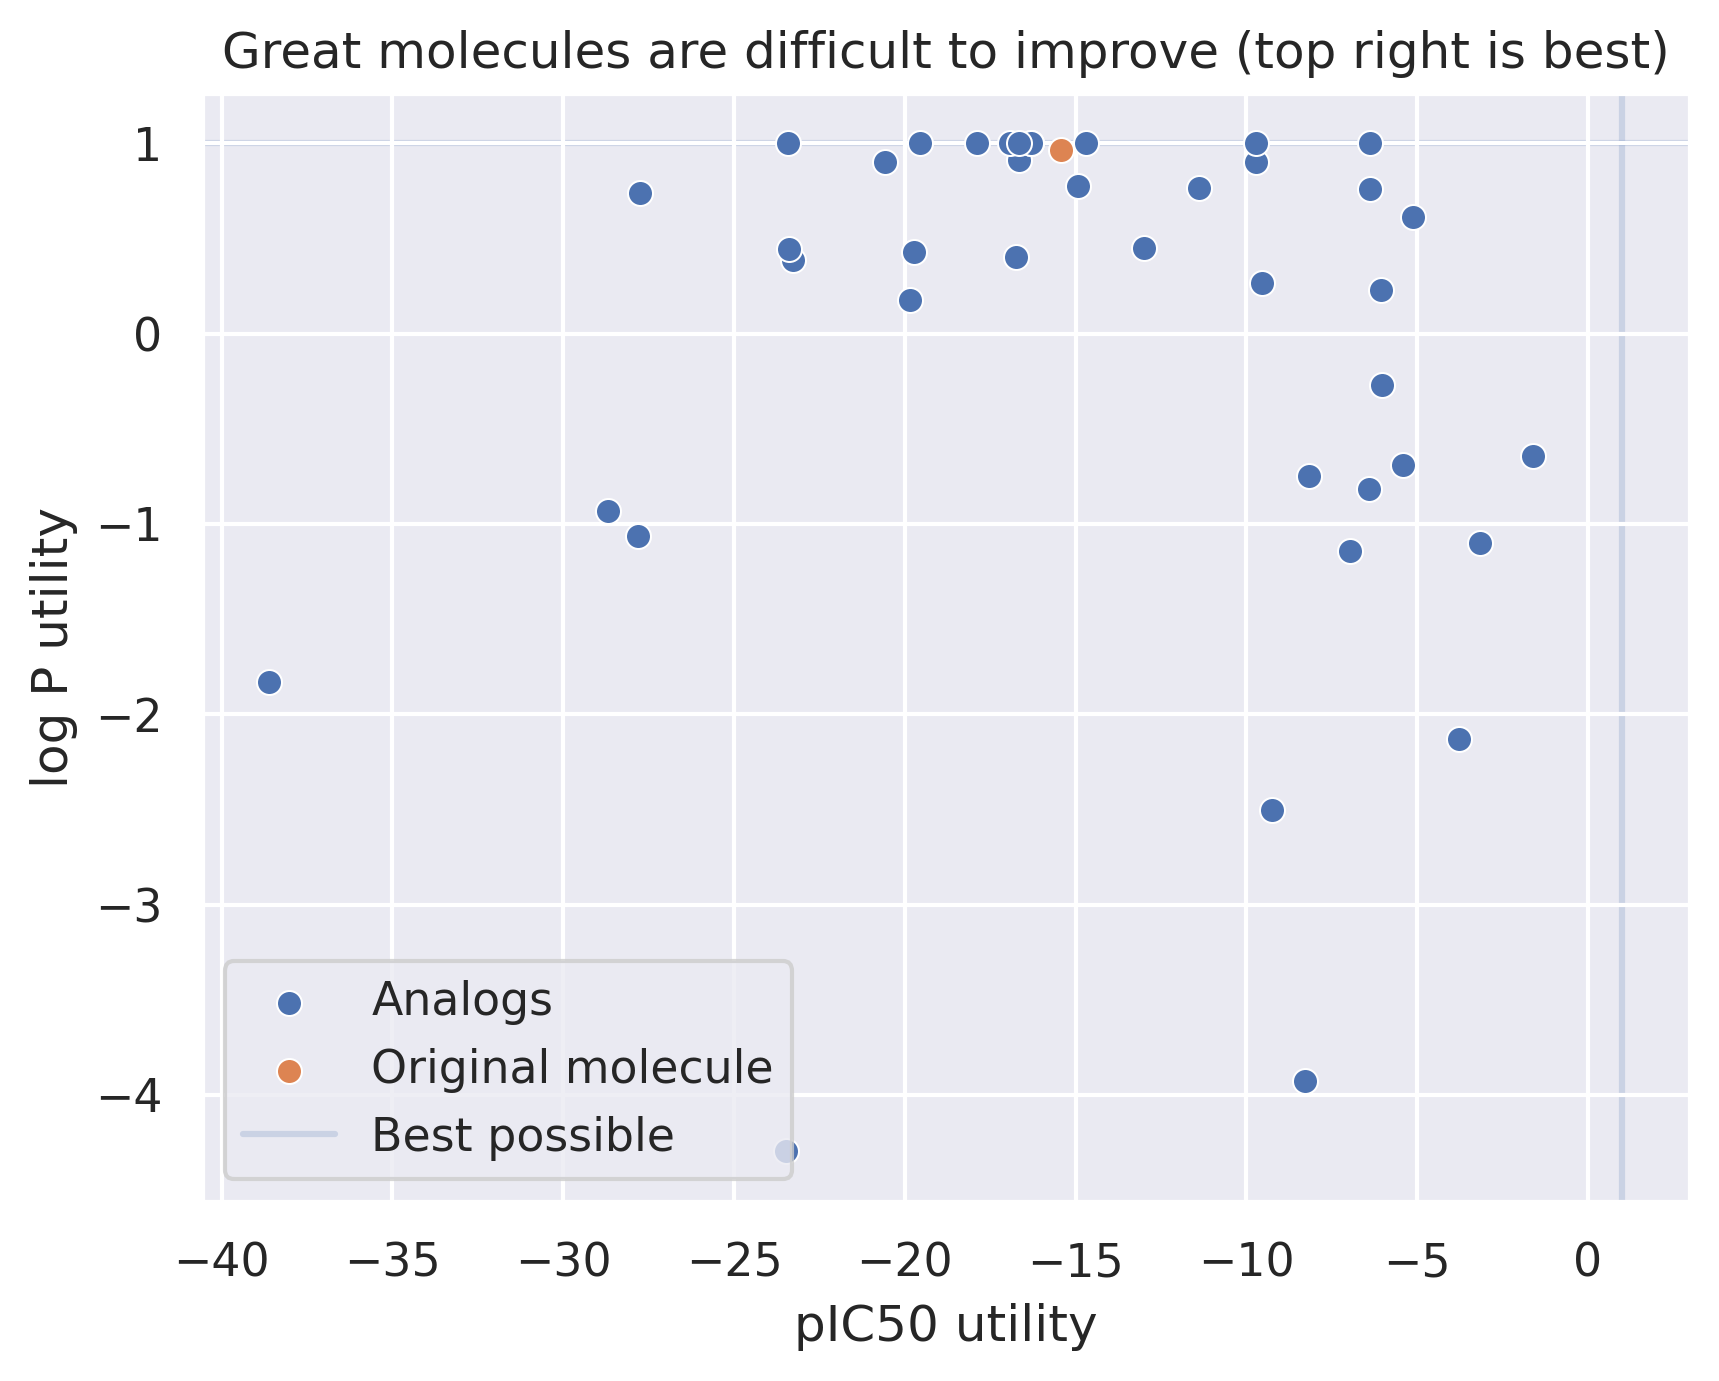

In [286]:
plt.figure(dpi=300)
g = sns.scatterplot(
    x=utility_functions[0](analogs), y=utility_functions[1](analogs),
    label='Analogs'
)
sns.scatterplot(
    x=[utility_functions[0](starting_molecule)], y=[utility_functions[1](starting_molecule)],
    label='Original molecule'
)

plt.axhline(1, alpha=0.2, zorder=-10)
plt.axvline(1, alpha=0.2, zorder=-10, label='Best possible')
plt.legend(loc='lower left')
plt.xlabel('pIC50 utility')
plt.ylabel('log P utility')
plt.title('Great molecules are difficult to improve (top right is best)')

In [111]:
pd.DataFrame([u(library) for u in assays]).T.sort_values(0, ascending=False).head(20)

,0,1,2
423,9.160565,2.36420,-5.941446
497,9.140953,4.57750,-5.705187
198,9.125629,4.73900,-5.003748
493,9.078657,3.92782,-4.935589
159,8.975799,3.61210,-5.368796
388,8.945720,4.69662,-5.455013
542,8.906631,4.09402,-3.845660
367,8.883729,5.10360,-5.913128
204,8.840534,4.62040,-5.405210
290,8.831222,3.51820,-4.493858


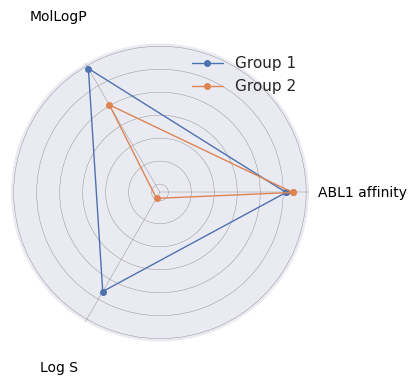

In [78]:
from radar import radar_chart
import matplotlib.pyplot as plt

annotations = (
    library.annotations.map(
    lambda x: x[0] if isinstance(x, list) else x)
    [[objective, 'MolLogP', 'Log S']]
)
best = np.argsort(-np.array(multiple_utility_function(library, method='average')))[[0, 4]]
values = multiple_utility_function.score(library)[best]
labels = annotations.columns

radar_chart(
    labels=labels, values=values, fill_alpha=0.0,
)
plt.show()

Docking on-disk.

In [168]:
results = docking_oracle(
    milestones,
    # path='../../dgym-data/out/docking_results',
    use_cache=False
)
results

[5.414583693778528,
 7.619178138277572,
 8.464572469784313,
 7.230776040265723,
 7.508294157316174,
 9.545399596310647]

In [169]:
docking_oracle(milestones)

[5.296790820592244,
 7.852951762053853,
 8.485377189191793,
 8.379315411720343,
 8.450697222951833,
 9.980465899262242]

## Manual selection experiments

In [307]:
[c(library[best]) for c in cost_functions]

[array([0.91376542, 1.30816624, 1.59607717, 0.93885823, 0.51481126]),
 array([0.        , 0.22036364, 0.        , 0.64957576, 0.84745455]),
 array([0.94758702, 0.79207573, 0.83260036, 0.85939413, 1.14689711])]

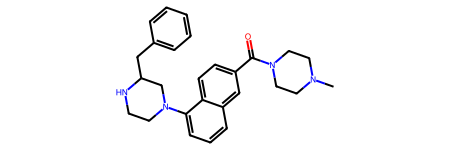

In [190]:
library[best][4]

In [733]:
mol = next(designer.construct_reaction({'product': 'O=C(c1ccc([C@@H]2Nc3c(Cl)cc(Cl)cc3[C@@H]3C=CC[C@@H]32)cc1)N1CC2C(C1)C(F)(F)C(F)(F)C(F)(F)C2(F)F',
 'reaction': '83_Schotten_Baumann_amide',
 'reactants': [{'product': 'Cl.FC1(F)C2CNCC2C(F)(F)C(F)(F)C1(F)F'},
  {'product': 'O=C(O)c1ccc([C@@H]2Nc3c(Cl)cc(Cl)cc3[C@@H]3C=CC[C@@H]32)cc1'}]}))

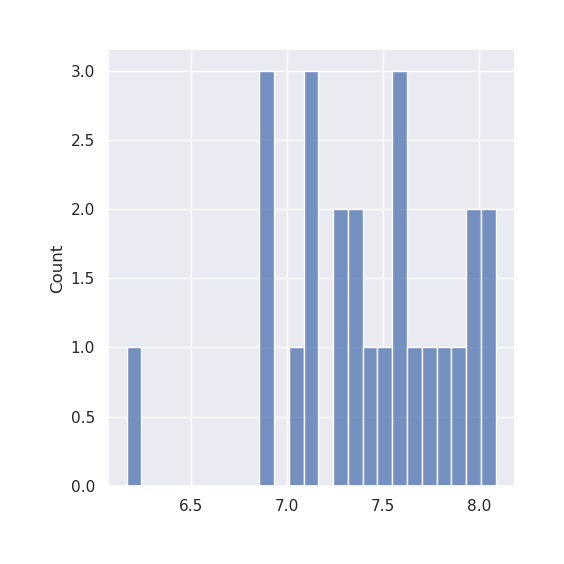

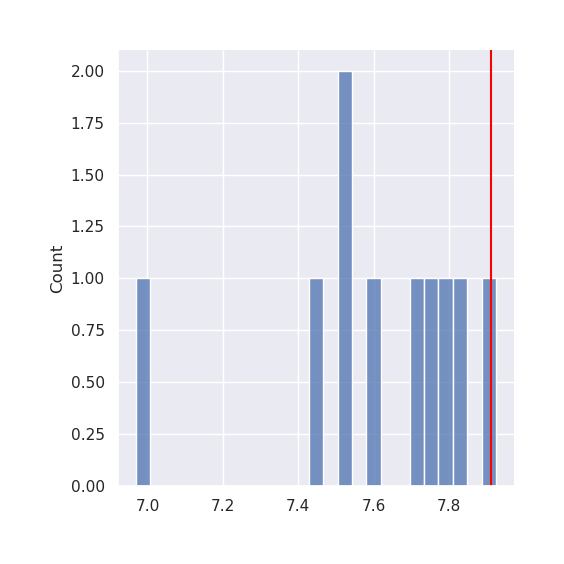

In [852]:
starting_point = library[477]
starting_point_replicates = docking_oracle([starting_point]*10, use_cache=False)

analogs = designer.design(
    starting_point, 25, strategy='replace', temperature=0.0)
analog_docking_scores = docking_oracle(analogs, use_cache=False)

sns.displot(analog_docking_scores, bins=25)
sns.displot(starting_point_replicates, bins=25)
plt.axvline(docking_oracle(library[477]), color='red')

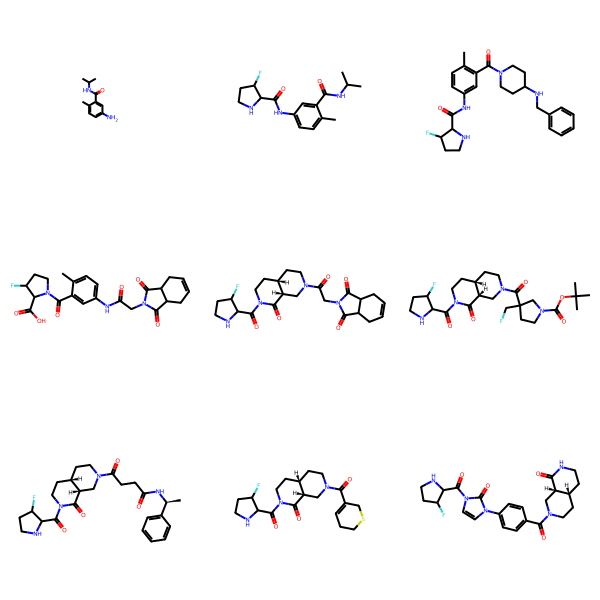

In [183]:
MolsToGridImage([l.mol for l in library[best[0]].lineage])

In [117]:
import tabulate
data = [["Sun",696000,1989100000],
         ["Earth",6371,5973.6],
         ["Moon",1737,73.5],
         ["Mars",3390,641.85]]

table = tabulate.tabulate(data, tablefmt='html')
table

Sun,696000,1.9891e+09
Earth,6371,5973.6
Moon,1737,73.5
Mars,3390,641.85
